## SECTOR A ##

## Package Imports ##

In [3]:
import warnings

# Import data loading and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Time serie components
from statsmodels.tsa.seasonal import seasonal_decompose

# Chequear la Estacionariedad. Prueba de Dickey Fuller Aumentada.
from statsmodels.tsa.stattools import adfuller

# Import for ts analysis
from statsmodels.tsa.seasonal import MSTL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from metrics import print_metrics

# hide warnings
warnings.filterwarnings("ignore")

SKTIME PACKAGE

In [4]:
# Import for ts forecasting
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split

from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.tbats import TBATS

from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import mean_absolute_error
from sktime.performance_metrics.forecasting import mean_squared_error

from sktime.utils.plotting import plot_series

## OBJETIVO: OBTENER MODELOS QUE PERMITAN HACER PREDICCIONES A CORTO PLAZO (DE UNA HORA). SHORT-TERM FORECASTING. ##

Load dataset and set correct data type timestamp column.

In [15]:
sector_data_full = 'sectorA_full.csv'
df = pd.read_csv(sector_data_full, usecols=['timestamp', 'A'], parse_dates=['timestamp'])

# Slicing Time Series. Set the column as the index of the dataframe.
df.set_index('timestamp', inplace=True)

# Rename column.
df = df.rename(columns={'A':'count'})

# Set frequency to 15 min.
df = df.asfreq('15T')

In [16]:
df.index

DatetimeIndex(['2023-01-01 00:15:00', '2023-01-01 00:30:00',
               '2023-01-01 00:45:00', '2023-01-01 01:00:00',
               '2023-01-01 01:15:00', '2023-01-01 01:30:00',
               '2023-01-01 01:45:00', '2023-01-01 02:00:00',
               '2023-01-01 02:15:00', '2023-01-01 02:30:00',
               ...
               '2024-01-01 11:30:00', '2024-01-01 11:45:00',
               '2024-01-01 12:00:00', '2024-01-01 12:15:00',
               '2024-01-01 12:30:00', '2024-01-01 12:45:00',
               '2024-01-01 13:00:00', '2024-01-01 13:15:00',
               '2024-01-01 13:30:00', '2024-01-01 13:45:00'],
              dtype='datetime64[ns]', name='timestamp', length=35095, freq='15min')

REMUESTREO HORARIO

In [6]:
# Esta variante mantiene los nombres de columnas
df_h = df.resample('h').mean()

In [7]:
df_h.index

DatetimeIndex(['2023-01-01 00:00:00', '2023-01-01 01:00:00',
               '2023-01-01 02:00:00', '2023-01-01 03:00:00',
               '2023-01-01 04:00:00', '2023-01-01 05:00:00',
               '2023-01-01 06:00:00', '2023-01-01 07:00:00',
               '2023-01-01 08:00:00', '2023-01-01 09:00:00',
               ...
               '2024-01-01 04:00:00', '2024-01-01 05:00:00',
               '2024-01-01 06:00:00', '2024-01-01 07:00:00',
               '2024-01-01 08:00:00', '2024-01-01 09:00:00',
               '2024-01-01 10:00:00', '2024-01-01 11:00:00',
               '2024-01-01 12:00:00', '2024-01-01 13:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=8774, freq='h')

(<Figure size 1600x400 with 1 Axes>,
 <Axes: xlabel='time stamps', ylabel='acft counts'>)

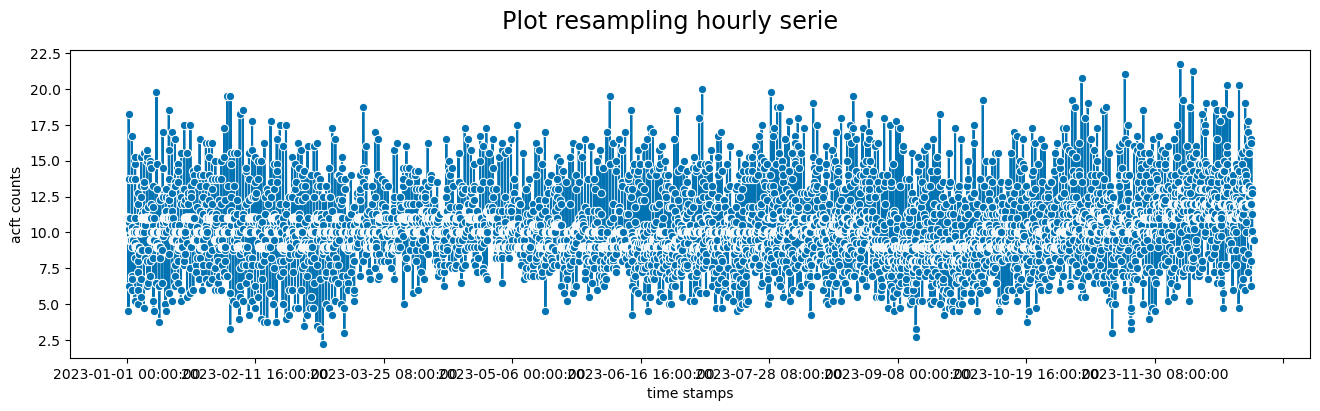

In [5]:
# Plotting for visualization using sktime library.
plot_series(df_h, title='Plot resampling hourly serie', y_label="acft counts", x_label="time stamps")

## PRONOSTICADORES (FORECASTERS) ##
- NaiveForecaster
- PipeLine (NaiveForecaster con transformer Deseasonalizer)
- ThetaForecaster
- TBATS (is ideal for time series datasets with complex seasonality)

Especificación del algoritmo de pronóstico:

- Todas las predicciones siguen el mismo flujo de trabajo sin importar qué pronosticador se elija.
- Todos los pronosticadores de sktime utilizan una interfaz similar a scikit-learn.
- Todos los pronosticadores usan un horizontes de prevision (fh - forecasting horizon).
- Los pipeline de sktime permiten encadenar transformadores con pronosticadores para obtener un unico objeto pronosticador.

----------------------
## NAIVE FORECASTER ##
----------------------

Using workflow.

A Naive Forecasting Model visualizes actual values vs. forecast values.
Setting a baseline accuracy is standard practice in time series forecasting, so we will accomplish that with a naive model. First of all, we use the temporal_train_test_split() function to split the series into a train and test set. Afterwards, we use the NaiveForecaster() class to create a naive model that always predicts the mean value of the train set. Finally, we plot the forecast and display the associated metrics with the print_metrics() function.

HACIENDO EL CORTE TRAIN/TEST EN DATOS REALES.

In [9]:
y = df['count']

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='count'>)

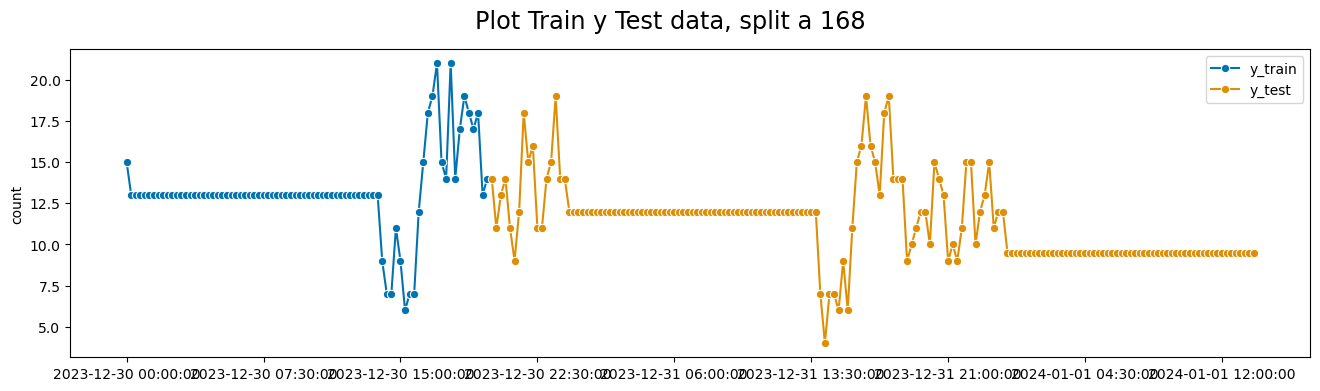

In [10]:
y_train_168, y_test_168 = temporal_train_test_split(y, test_size=168)

# plot and print results
plot_series(y_train_168['2023-12-30':], y_test_168, title='Plot Train y Test data, split a 168', labels=[ "y_train" , "y_test" ])

In [11]:
y_train_168

timestamp
2023-01-01 00:15:00    11.0
2023-01-01 00:30:00    11.0
2023-01-01 00:45:00    11.0
2023-01-01 01:00:00    11.0
2023-01-01 01:15:00    11.0
                       ... 
2023-12-30 18:45:00    18.0
2023-12-30 19:00:00    17.0
2023-12-30 19:15:00    18.0
2023-12-30 19:30:00    13.0
2023-12-30 19:45:00    14.0
Freq: 15min, Name: count, Length: 34927, dtype: float64

In [12]:
y_test_168

2023-12-30 20:00:00    14.0
2023-12-30 20:15:00    11.0
2023-12-30 20:30:00    13.0
2023-12-30 20:45:00    14.0
2023-12-30 21:00:00    11.0
                       ... 
2024-01-01 12:45:00     9.5
2024-01-01 13:00:00     9.5
2024-01-01 13:15:00     9.5
2024-01-01 13:30:00     9.5
2024-01-01 13:45:00     9.5
Freq: 15min, Name: count, Length: 168, dtype: float64

HACIENDO EL CORTE TRAIN/TEST EN DATOS RELLENADOS.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='count'>)

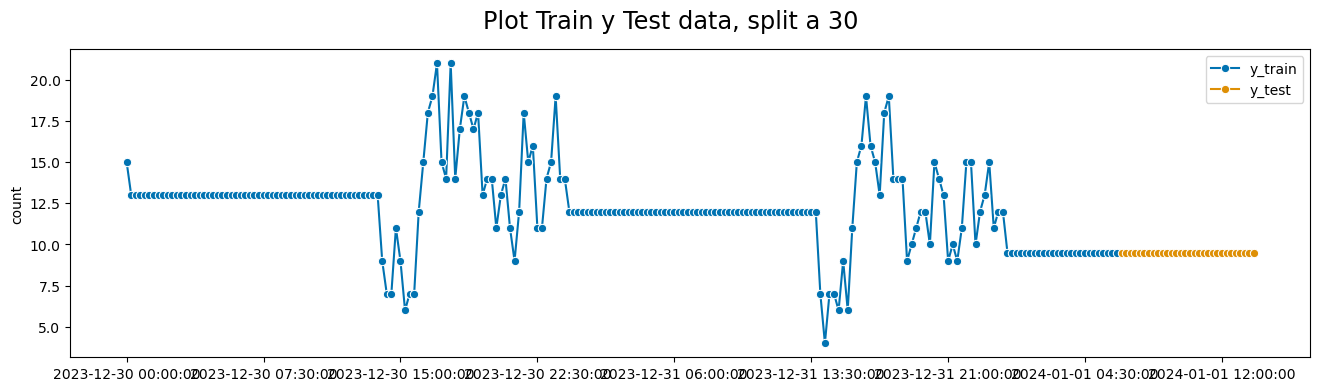

In [13]:
y_train_30, y_test_30 = temporal_train_test_split(y, test_size=30)

# plot and print results
plot_series(y_train_30['2023-12-30':], y_test_30, title='Plot Train y Test data, split a 30', labels=[ "y_train" , "y_test" ])

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='count'>)

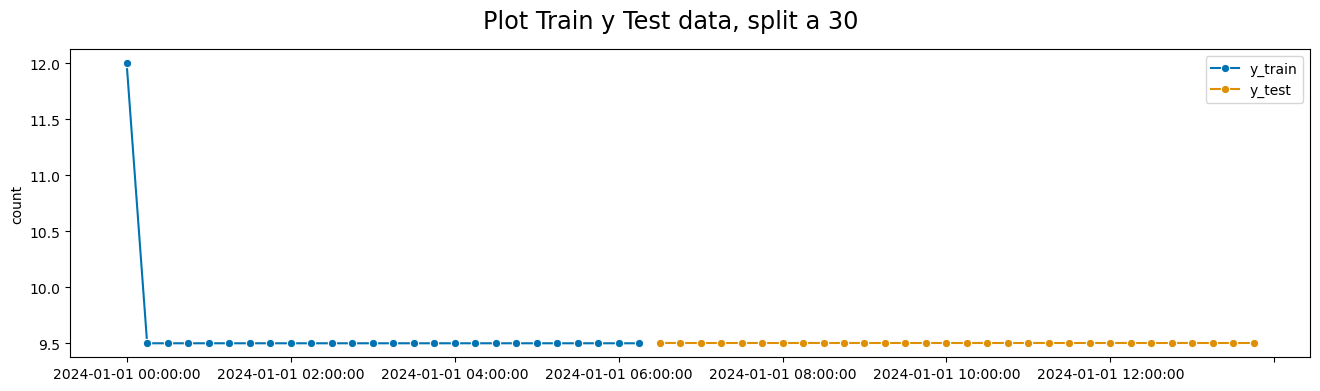

In [14]:
# plot and print results
plot_series(y_train_30['2024-01-01':], y_test_30, title='Plot Train y Test data, split a 30', labels=[ "y_train" , "y_test" ])

- PREDICCION EN LAS HORAS DONDE HAY DATOS REGISTRADOS.

> Train: 34927 Test: 168
> Predicted: 
2023-12-30 20:00:00    14.0
2023-12-30 20:15:00    14.0
2023-12-30 20:30:00    14.0
2023-12-30 20:45:00    14.0
Name: count, dtype: float64

> Subset test datapoints to compare: 
2023-12-30 20:00:00    14.0
2023-12-30 20:15:00    11.0
2023-12-30 20:30:00    13.0
2023-12-30 20:45:00    14.0
Freq: 15min, Name: count, dtype: float64
                  MAE  RMSE  MAPE  SMAPE
Naive Forecaster  1.0  1.58  0.09   0.08


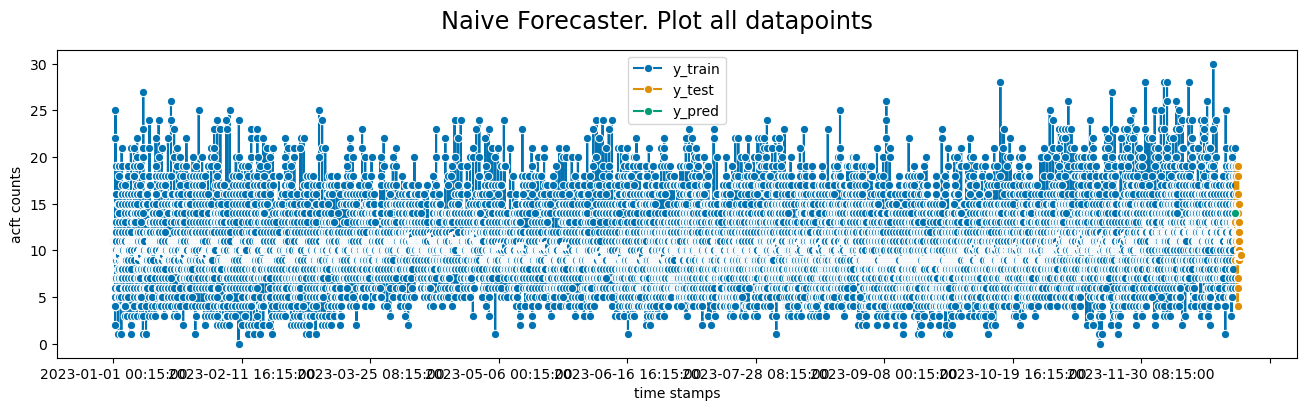

In [30]:
# Prepare data.
y = df['count']

# Split data in TRAIN and TESTING, 70% TRAIN, 30 TEST.
y_train, y_test = temporal_train_test_split(y, test_size = 168)

# specifying forecaster
forecaster = NaiveForecaster(strategy="last")

# fitting the forescaster. Pasando a fit() el fh.
forecaster.fit (y_train, fh=[1,2,3,4])

# querying prediction
y_pred = forecaster.predict()

# plot and print results
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], y_label="acft counts", x_label="time stamps", title='Naive Forecaster. Plot all datapoints')

print(f'> Train: {y_train.shape[0]}', f'Test: {y_test.shape[0]}')
print(f'> Predicted: \n{y_pred}')

# evaluate metrics in range fh
y_test_eval = y_test.iloc[:4]
print(f'\n> Test datapoints subset to compare: \n{y_test_eval}')
metrics_nvf_1 = print_metrics(y_test_eval, y_pred, 'Naive Forecaster')
print(metrics_nvf_1)

In [19]:
y_train.describe()

count    34927.000000
mean        10.201721
std          2.583632
min          0.000000
25%          9.000000
50%         10.000000
75%         11.000000
max         30.000000
Name: count, dtype: float64

In [20]:
y_train.median()

10.0

In [21]:
y_test.describe()

count    168.000000
mean      11.330357
std        2.356562
min        4.000000
25%        9.500000
50%       12.000000
75%       12.000000
max       19.000000
Name: count, dtype: float64

In [22]:
y_test['2023-12-30 20:00:00':'2023-12-30 20:45:00']

2023-12-30 20:00:00    14.0
2023-12-30 20:15:00    11.0
2023-12-30 20:30:00    13.0
2023-12-30 20:45:00    14.0
Freq: 15min, Name: count, dtype: float64

In [23]:
y_test['2023-12-30 20:00:00':'2023-12-30 20:45:00'].median()

13.5

In [24]:
y_train['2023-12-30':]

2023-12-30 00:00:00    15.0
2023-12-30 00:15:00    13.0
2023-12-30 00:30:00    13.0
2023-12-30 00:45:00    13.0
2023-12-30 01:00:00    13.0
                       ... 
2023-12-30 18:45:00    18.0
2023-12-30 19:00:00    17.0
2023-12-30 19:15:00    18.0
2023-12-30 19:30:00    13.0
2023-12-30 19:45:00    14.0
Freq: 15min, Name: count, Length: 80, dtype: float64

(<Figure size 1600x400 with 1 Axes>,
 <Axes: xlabel='time stamps', ylabel='acft counts'>)

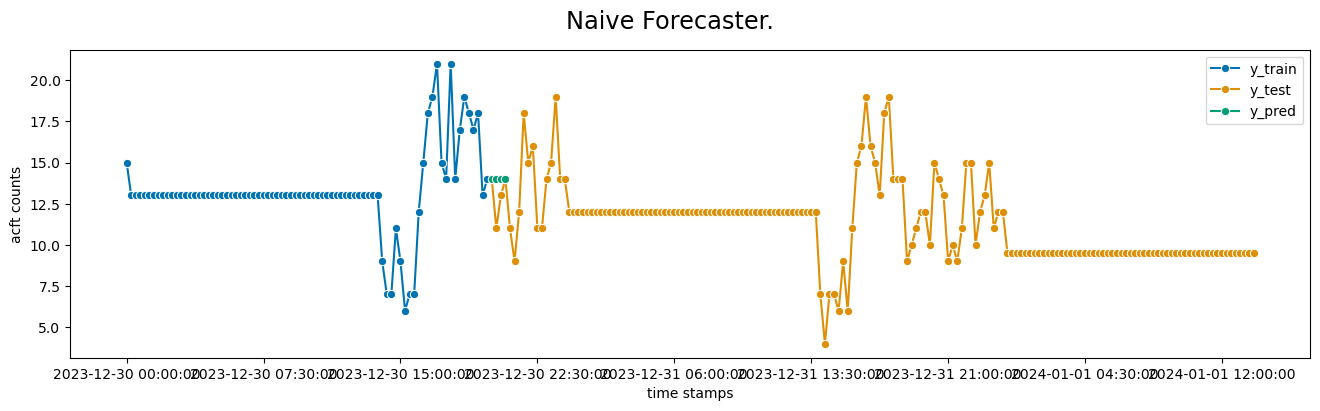

In [25]:
plot_series(y_train['2023-12-30':], y_test, y_pred, labels=["y_train", "y_test", "y_pred"], y_label="acft counts", x_label="time stamps", title='Naive Forecaster.')

- PREDICCION EN LAS HORAS DONDE SE RELLENARON LOS DATOS.

Train: 35065 Test: 30
Predicted: 
2024-01-01 06:30:00    9.5
2024-01-01 06:45:00    9.5
2024-01-01 07:00:00    9.5
2024-01-01 07:15:00    9.5
Name: count, dtype: float64

> Test datapoints subset to compare: 
timestamp
2024-01-01 06:30:00    9.5
2024-01-01 06:45:00    9.5
2024-01-01 07:00:00    9.5
2024-01-01 07:15:00    9.5
Freq: 15min, Name: count, dtype: float64
                  MAE  RMSE  MAPE  SMAPE
Naive Forecaster  0.0   0.0   0.0    0.0


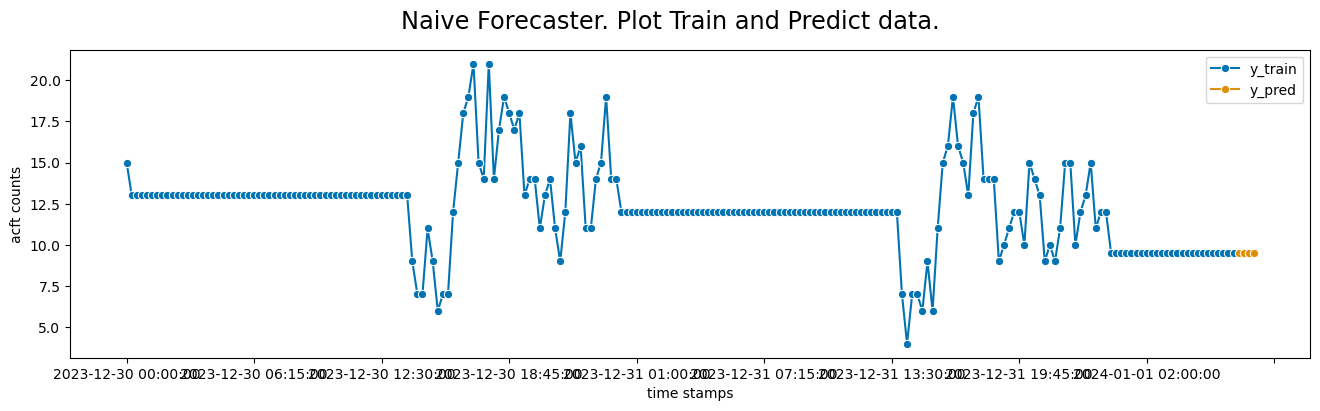

In [31]:
# Prepare data.
y = df['count']
y_train, y_test = temporal_train_test_split(y, test_size=30)

# specifying forecaster
forecaster = NaiveForecaster(strategy="last")

# fitting the forescaster with y_train
forecaster.fit(y_train)

# querying predictions, pasando e predict el forecasting horizon 4 step ahead, fh=4
y_pred = forecaster.predict(fh=[1,2,3,4])

# plot and print results
plot_series(y_train['2023-12-30':], y_pred, labels=["y_train", "y_pred"], y_label="acft counts", x_label="time stamps", title='Naive Forecaster. Plot Train and Predict data.')

print(f'Train: {y_train.shape[0]}', f'Test: {y_test.shape[0]}')
print(f'Predicted: \n{y_pred}')

# evaluate metrics in range fh
y_test_eval = y_test.iloc[:4]
print(f'\n> Test datapoints subset to compare: \n{y_test_eval}')
metrics_nvf_2 = print_metrics(y_test_eval, y_pred, 'Naive Forecaster')
print(metrics_nvf_2)

(<Figure size 1600x400 with 1 Axes>,
 <Axes: xlabel='time stamps', ylabel='acft counts'>)

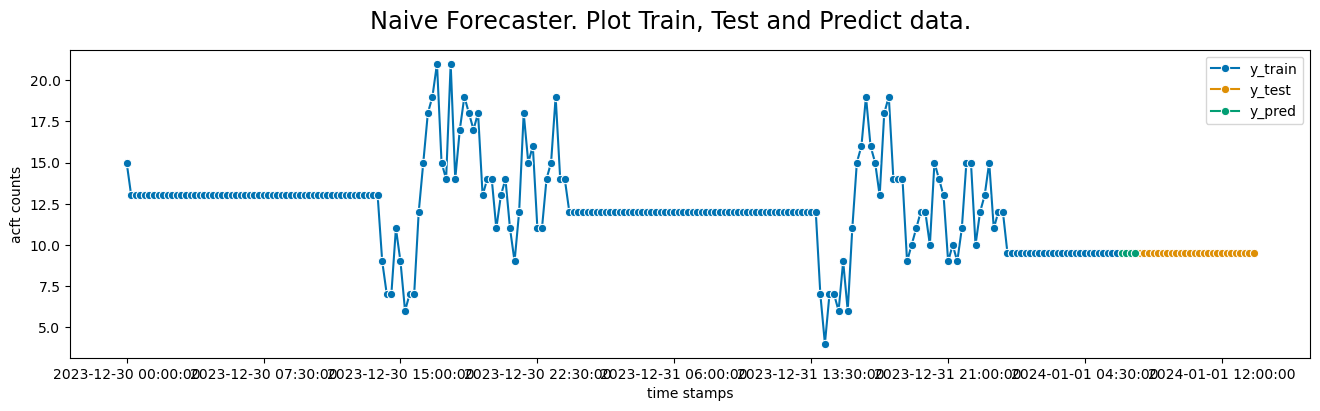

In [32]:
plot_series(y_train['2023-12-30':], y_test, y_pred, labels=["y_train", "y_test", "y_pred"], y_label="acft counts", x_label="time stamps", title='Naive Forecaster. Plot Train, Test and Predict data.')

## Predicciones a largo plazo ##

PREPARE fh with ForecastingHorizon object.

In [36]:
# Prepare hourly resampled data.
y_h = df_h['count']

y_train_h, y_test_h = temporal_train_test_split(y_h, test_size=168)

fh_h = ForecastingHorizon(y_test_h.index, is_relative=False, freq='h')
fh_h

ForecastingHorizon(['2023-12-25 14:00:00', '2023-12-25 15:00:00',
               '2023-12-25 16:00:00', '2023-12-25 17:00:00',
               '2023-12-25 18:00:00', '2023-12-25 19:00:00',
               '2023-12-25 20:00:00', '2023-12-25 21:00:00',
               '2023-12-25 22:00:00', '2023-12-25 23:00:00',
               ...
               '2024-01-01 04:00:00', '2024-01-01 05:00:00',
               '2024-01-01 06:00:00', '2024-01-01 07:00:00',
               '2024-01-01 08:00:00', '2024-01-01 09:00:00',
               '2024-01-01 10:00:00', '2024-01-01 11:00:00',
               '2024-01-01 12:00:00', '2024-01-01 13:00:00'],
              dtype='datetime64[ns]', length=168, freq='h', is_relative=False)

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

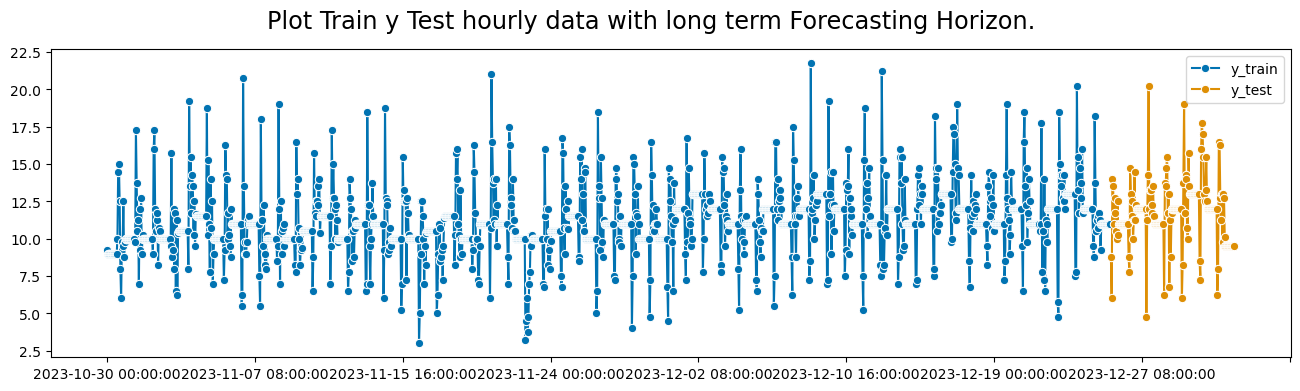

In [41]:
# plot splitted data
plot_series(y_train_h['2023-10-30':], y_test_h, title='Plot Train y Test hourly data with long term Forecasting Horizon.', labels=[ "y_train" , "y_test" ])

Hourly Prediction

> Train: 8606 Test: 168
> Predicted: 
2023-12-25 14:00:00    11.0
2023-12-25 15:00:00    11.0
2023-12-25 16:00:00    11.0
2023-12-25 17:00:00    11.0
2023-12-25 18:00:00    11.0
                       ... 
2024-01-01 09:00:00    11.0
2024-01-01 10:00:00    11.0
2024-01-01 11:00:00    11.0
2024-01-01 12:00:00    11.0
2024-01-01 13:00:00    11.0
Length: 168, dtype: float64

> Test data: 
2023-12-25 14:00:00     8.75
2023-12-25 15:00:00     6.00
2023-12-25 16:00:00    14.00
2023-12-25 17:00:00    13.50
2023-12-25 18:00:00    11.00
                       ...  
2024-01-01 09:00:00     9.50
2024-01-01 10:00:00     9.50
2024-01-01 11:00:00     9.50
2024-01-01 12:00:00     9.50
2024-01-01 13:00:00     9.50
Freq: h, Length: 168, dtype: float64
                   MAE  RMSE  MAPE  SMAPE
Naive Forecaster  1.69  2.34  0.15   0.15


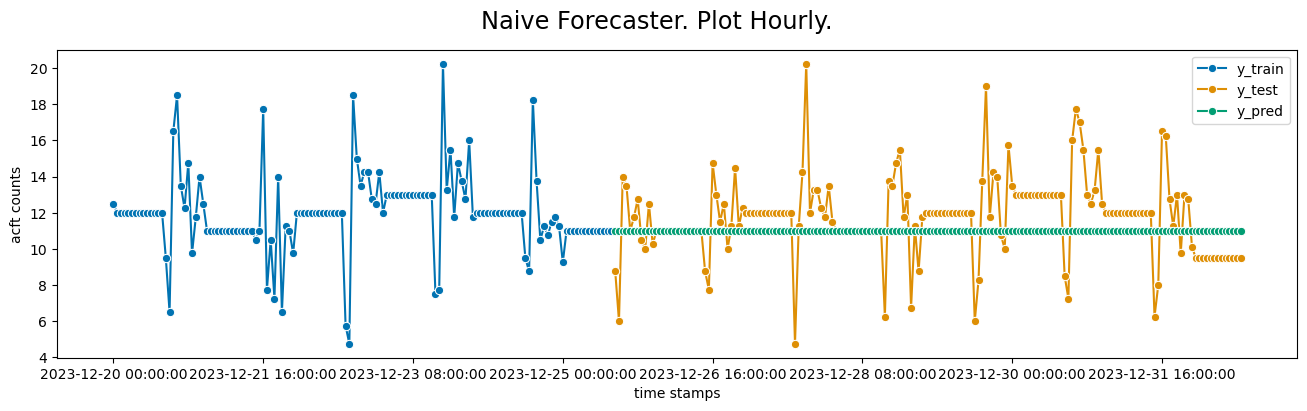

In [52]:
forecaster = NaiveForecaster(strategy="last")    #, sp=12 season period (sp) is set to 12, monthly seasonal periodicity

forecaster.fit(y_train_h)

# y_pred will contain the predictions
y_pred_h = forecaster.predict(fh_h)

# plot and print results
plot_series(y_train_h['2023-12-20':], y_test_h, y_pred_h, labels=["y_train", "y_test", "y_pred"], y_label="acft counts", x_label="time stamps", title='Naive Forecaster. Plot Hourly.')

print(f'> Train: {y_train_h.shape[0]}', f'Test: {y_test_h.shape[0]}')
print(f'> Predicted: \n{y_pred_h}')

print(f'\n> Test data: \n{y_test_h}')
metrics_nvf_3 = print_metrics(y_test_h, y_pred_h, 'Naive Forecaster')
print(metrics_nvf_3)

CRUD DATA

In [53]:
# Prepare crud data.
y = df['count']

y_train, y_test = temporal_train_test_split(y, test_size=168)

# We can take the indices from `y_test`.
fh = ForecastingHorizon(y_test.index, is_relative=False, freq='15T')
fh

ForecastingHorizon(['2023-12-30 20:00:00', '2023-12-30 20:15:00',
               '2023-12-30 20:30:00', '2023-12-30 20:45:00',
               '2023-12-30 21:00:00', '2023-12-30 21:15:00',
               '2023-12-30 21:30:00', '2023-12-30 21:45:00',
               '2023-12-30 22:00:00', '2023-12-30 22:15:00',
               ...
               '2024-01-01 11:30:00', '2024-01-01 11:45:00',
               '2024-01-01 12:00:00', '2024-01-01 12:15:00',
               '2024-01-01 12:30:00', '2024-01-01 12:45:00',
               '2024-01-01 13:00:00', '2024-01-01 13:15:00',
               '2024-01-01 13:30:00', '2024-01-01 13:45:00'],
              dtype='datetime64[ns]', name='timestamp', length=168, freq='15min', is_relative=False)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='count'>)

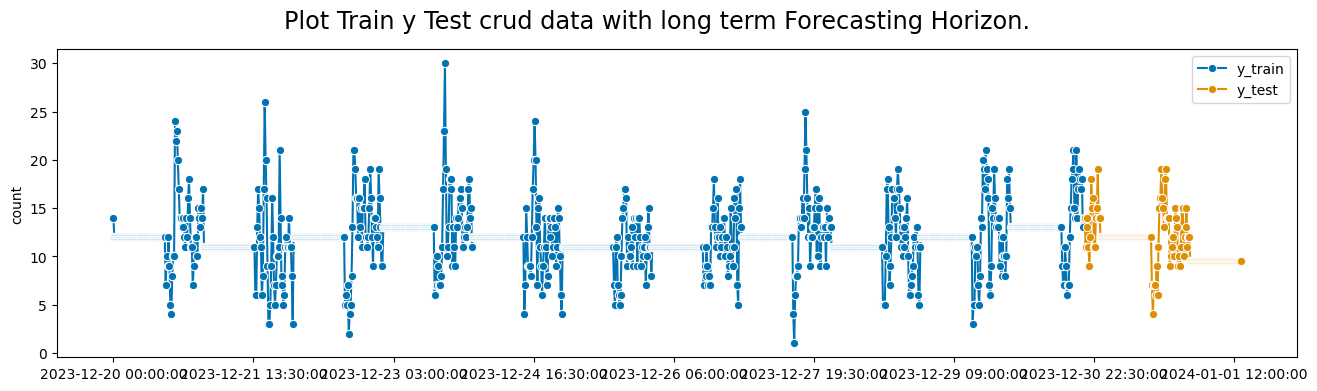

In [54]:
# plot splitted data
plot_series(y_train['2023-12-20':], y_test, title='Plot Train y Test crud data with long term Forecasting Horizon.', labels=[ "y_train" , "y_test" ])

> Train: 34927 Test: 168
> Predicted: 
2023-12-30 20:00:00     NaN
2023-12-30 20:15:00     NaN
2023-12-30 20:30:00     NaN
2023-12-30 20:45:00     NaN
2023-12-30 21:00:00     NaN
                       ... 
2024-01-01 12:45:00     NaN
2024-01-01 13:00:00    13.0
2024-01-01 13:15:00     NaN
2024-01-01 13:30:00     NaN
2024-01-01 13:45:00    14.0
Freq: 15min, Name: count, Length: 168, dtype: float64

> Test data: 
2023-12-30 20:00:00    14.0
2023-12-30 20:15:00    11.0
2023-12-30 20:30:00    13.0
2023-12-30 20:45:00    14.0
2023-12-30 21:00:00    11.0
                       ... 
2024-01-01 12:45:00     9.5
2024-01-01 13:00:00     9.5
2024-01-01 13:15:00     9.5
2024-01-01 13:30:00     9.5
2024-01-01 13:45:00     9.5
Freq: 15min, Name: count, Length: 168, dtype: float64
Error, MAPE metrics....
0


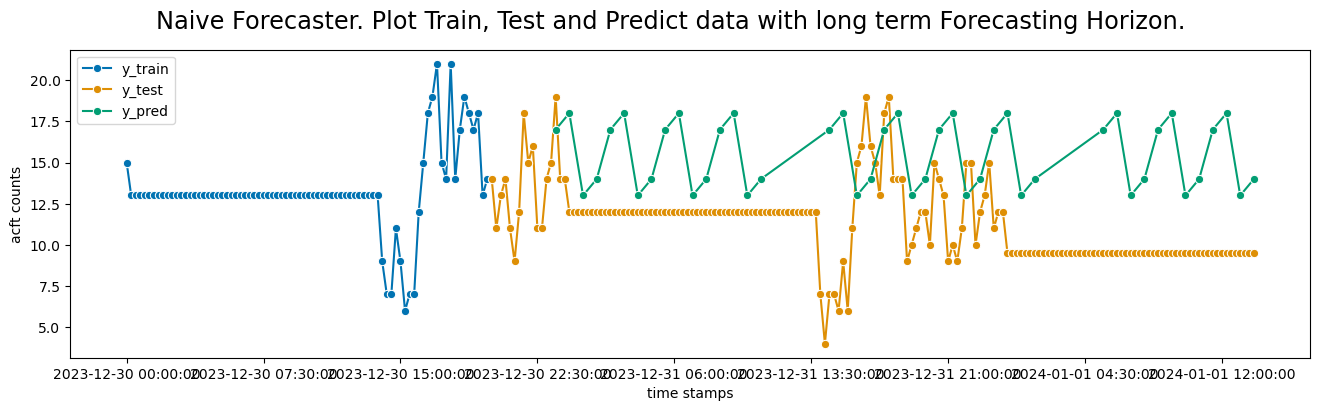

In [59]:
forecaster = NaiveForecaster(strategy="last", sp=12)    #, sp=12 season period (sp) is set to 12, monthly seasonal periodicity

forecaster.fit(y_train)

# y_pred will contain the predictions
y_pred = forecaster.predict(fh)

# plot and print results
plot_series(y_train['2023-12-30':], y_test, y_pred, labels=["y_train", "y_test", "y_pred"], y_label="acft counts", x_label="time stamps", title='Naive Forecaster. Plot Train, Test and Predict data with long term Forecasting Horizon.')

print(f'> Train: {y_train.shape[0]}', f'Test: {y_test.shape[0]}')
print(f'> Predicted: \n{y_pred}')

print(f'\n> Test data: \n{y_test}')
metrics_nvf_4 = print_metrics(y_test, y_pred, 'Naive Forecaster')
print(metrics_nvf_4)

---------------------
## ThetaForecaster ##
---------------------

ThetaForecaster()
- Season period is set to 12, which is 12 months, 1 year
- monthly, seasonly, periodically
- 1 indicates yearly, 12 indicates monthly, and 4 indicates quarterly

season_length : int
    Number of observations per unit of time. Ex: 24 Hourly data.

... data that are observed every minute might have an hourly seasonality (frequency=60), a daily seasonality (frequency=24x60=1440), a weekly seasonality (frequency=24x60x7=10080) and an annual seasonality (frequency=24x60x365.25=525960)

sp=12, monthly seasonal periodicity

In [61]:
from sktime.utils import plotting

> Train: 8606 Test: 168
> Predicted: 
2023-12-25 14:00:00     9.985293
2023-12-25 15:00:00    12.374857
2023-12-25 16:00:00    13.034974
2023-12-25 17:00:00    11.851832
2023-12-25 18:00:00    11.760893
                         ...    
2024-01-01 09:00:00    10.912142
2024-01-01 10:00:00    11.873310
2024-01-01 11:00:00    10.582058
2024-01-01 12:00:00    10.989988
2024-01-01 13:00:00    11.198899
Freq: h, Length: 168, dtype: float64

> Test data: 
2023-12-25 14:00:00     8.75
2023-12-25 15:00:00     6.00
2023-12-25 16:00:00    14.00
2023-12-25 17:00:00    13.50
2023-12-25 18:00:00    11.00
                       ...  
2024-01-01 09:00:00     9.50
2024-01-01 10:00:00     9.50
2024-01-01 11:00:00     9.50
2024-01-01 12:00:00     9.50
2024-01-01 13:00:00     9.50
Freq: h, Length: 168, dtype: float64
                   MAE  RMSE  MAPE  SMAPE
Naive Forecaster  1.63  2.21  0.15   0.14


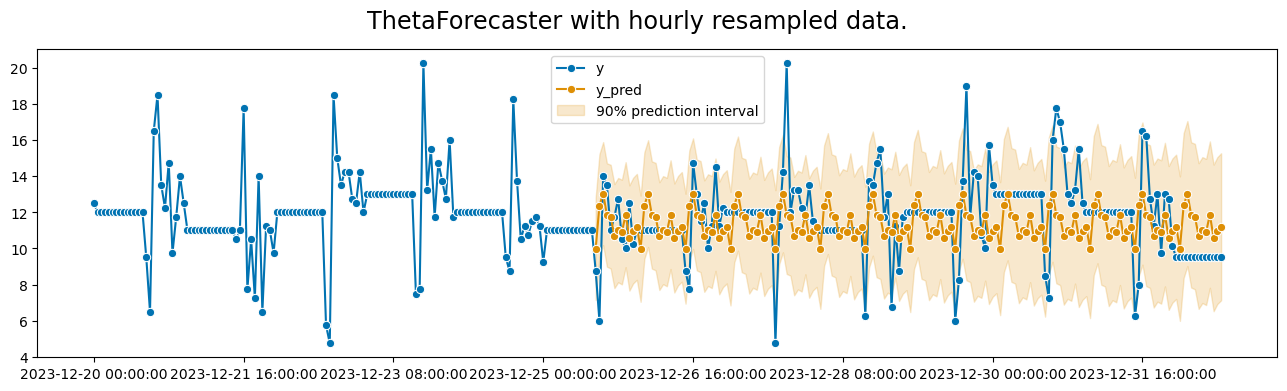

In [62]:
# specifying forecaster
# fh = np.arange(1, 13)
forecaster_t = ThetaForecaster(sp=12)

# fitting the forescaster
forecaster_t.fit (y_train_h, fh=fh_h)

coverage = 0.9
y_pred_ints = forecaster_t.predict_interval(coverage=coverage)

# querying prediction
y_pred_t = forecaster_t.predict()

# plot and print results
fig, ax = plotting.plot_series(y_h['2023-12-20':], y_pred_t, labels=['y', 'y_pred'], pred_interval=y_pred_ints, title='ThetaForecaster with hourly resampled data.')

print(f'> Train: {y_train_h.shape[0]}', f'Test: {y_test_h.shape[0]}')
print(f'> Predicted: \n{y_pred_t}')

print(f'\n> Test data: \n{y_test_h}')
metrics_ttf_1 = print_metrics(y_test_h, y_pred_t, 'Naive Forecaster')
print(metrics_ttf_1)

PLOT RESULT ThetaForecaster.

Para los datos horarios, los datos con freq=15min tenian valores zero, que es un valor valido. Se aplico un resamplig horario por:
"Multiplicative seasonality is not appropiate for zero and negative values...."

(<Figure size 1600x400 with 1 Axes>,
 <Axes: xlabel='time stamps', ylabel='acft counts'>)

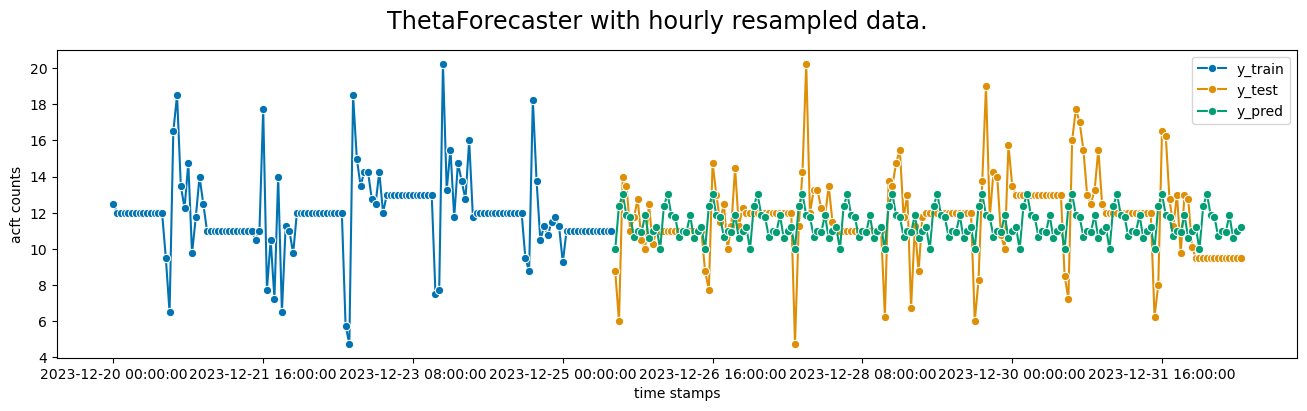

In [63]:
# plot and print results
plot_series(y_train_h['2023-12-20':], y_test_h, y_pred_t, labels=["y_train", "y_test", "y_pred"], y_label="acft counts", x_label="time stamps", title='ThetaForecaster with hourly resampled data.')

---------------------
## SKTIME PIPELINE ##
---------------------

Sktime permite encadenar transformadores con pronosticadores para obtener un unico objeto pronosticador.
- Probar un NaiveForecaster con un Deseasonalizer mensual usando un sktime pipeline TransformedTargetForecaster

In [64]:
from sktime.forecasting.compose import TransformedTargetForecaster, ForecastingPipeline
from sktime.transformations.series.detrend import Deseasonalizer 

> Train: 34927 Test: 168
> Predicted: 
2023-12-30 20:00:00    13.236397
2023-12-30 20:15:00    13.295977
2023-12-30 20:30:00    13.507474
2023-12-30 20:45:00    13.598353
2023-12-30 21:00:00    13.657675
                         ...    
2024-01-01 12:45:00    14.125442
2024-01-01 13:00:00    14.235002
2024-01-01 13:15:00    14.231378
2024-01-01 13:30:00    14.110188
2024-01-01 13:45:00    14.000000
Name: count, Length: 168, dtype: float64

> Test data: 
2023-12-30 20:00:00    14.0
2023-12-30 20:15:00    11.0
2023-12-30 20:30:00    13.0
2023-12-30 20:45:00    14.0
2023-12-30 21:00:00    11.0
                       ... 
2024-01-01 12:45:00     9.5
2024-01-01 13:00:00     9.5
2024-01-01 13:15:00     9.5
2024-01-01 13:30:00     9.5
2024-01-01 13:45:00     9.5
Freq: 15min, Name: count, Length: 168, dtype: float64
                   MAE  RMSE  MAPE  SMAPE
Naive Forecaster  3.02  3.46  0.31   0.25


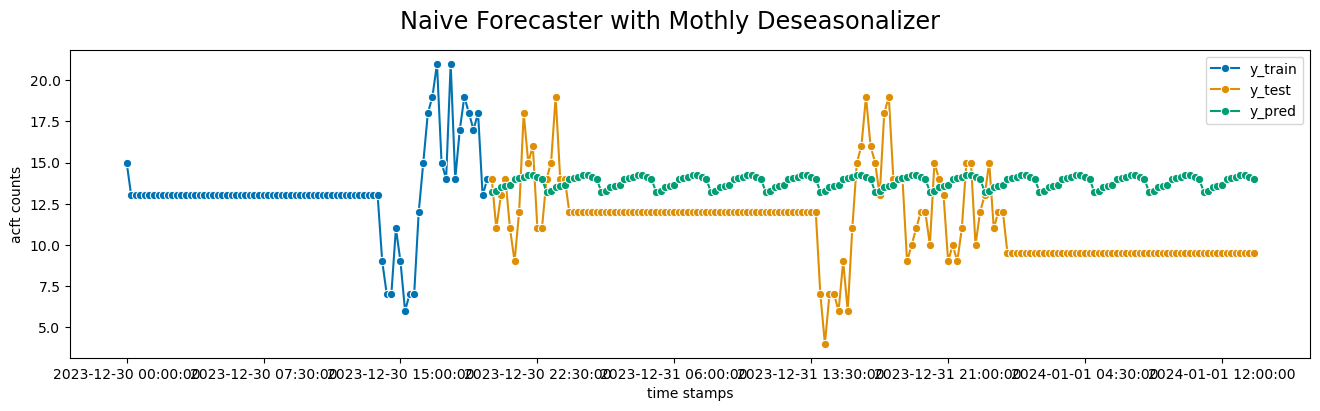

In [69]:
forecaster = TransformedTargetForecaster ([
    (" deseasonalise ", Deseasonalizer(sp=12) ), # monthly seasonal periodicity
    (" forecast ", NaiveForecaster( strategy ="last") )
    ])
forecaster.fit (y_train)
y_pred_p = forecaster.predict(fh=fh)

# plot and print results
plot_series(y_train['2023-12-30':], y_test, y_pred_p, labels=["y_train", "y_test", "y_pred"], y_label="acft counts", x_label="time stamps", title='Naive Forecaster with Mothly Deseasonalizer')

print(f'> Train: {y_train.shape[0]}', f'Test: {y_test.shape[0]}')
print(f'> Predicted: \n{y_pred_p}')

print(f'\n> Test data: \n{y_test}')
metrics_plnvf_1 = print_metrics(y_test, y_pred_p, 'Naive Forecaster')
print(metrics_plnvf_1)

----------
# MSTL #
### Multiple Seasonal-Trend decomposition using Loess. ###
----------

- Loess short for Locally Estimated Scatterplot Smoothing


### Multi-Seasonal Time Series Decomposition using MSTL in Python ###

MSTL módulo recién agregado en Statsmodels.

Existen modulos para descomponer una serie temporal en un componente de tendencia, un componente estacional y un componente residual. Pero ¿qué pasa con las series temporales que tienen múltiples componentes estacionales?

ANALISIS DE CASOS DE USO.

- En los sectores de control ATC se verifica constantemente la demanda y capacidad de los mismos. La demanda de aeronaves tiene una estacionalidad diaria (más demanda durante el día que a altas horas de la noche), una estacionalidad semanal (fines de semana frente a días laborables y semana santa) y una estacionalidad anual (la demanda en verano e invierno difiere debido a la temporada de alta y baja). La demanda se registra con una granularidad de 15 minutos.

Los métodos que pueden extraer múltiples componentes estacionales incluyen Prophet, TBATS y STR. Prophet y TBATS infieren los componentes estacionales como parte del entrenamiento de un modelo de pronóstico. En cambio, MSTL se centra directamente en descomponer una serie de tiempo.

¿Qué es MSTL?

MSTL significa descomposición de tendencias estacionales múltiples utilizando Loess (short for Locally Estimated Scatterplot Smoothing). Es un método para descomponer una serie temporal en un componente de tendencia, múltiples componentes estacionales y un componente residual. MSTL supone que la serie temporal se puede expresar como una descomposición aditiva donde cada componente estacional representa una estacionalidad diferente (por ejemplo, diaria, semanal, anual, etc.). MSTL se basa en STL (short for Seasonal-Trend decomposition using Loess) para extraer de forma iterativa cada uno de los componentes estacionales.

Parámetros MSTL

En la práctica, los parámetros más importantes:

- periods: el período de cada componente estacional, period pasado a STL (por ejemplo, para datos horarios con estacionalidad diaria y semanal, configuramos periods = (24, 24*7));
- windows: los tamaños de ventana estacionales, seasonal pasados ​​a STL para cada componente estacional respectivo (por ejemplo, windows = (11, 15)). MSTL utiliza valores predeterminados basados ​​en experimentos que dieron los mejores resultados;
- seasonal_deg: el grado del polinomio para el componente estacional utilizado es seasonal_deg = 0;
- lmbda: si se requiere una transformación de Box Cox, entonces debemos elegir un valor para el parámetro λ de una transformación de Box Cox. λ se puede configurar manualmente, lmbda=0.7 o automáticamente lmbda="auto".

In [8]:
# Dataframe hourly
df_h.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8774 entries, 2023-01-01 00:00:00 to 2024-01-01 13:00:00
Freq: h
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   count   8774 non-null   float64
dtypes: float64(1)
memory usage: 137.1 KB


## Analisis de componentes para Multiple Season, Diario(24) y Semanal(24*7). ##

                     seasonal_24  seasonal_168
timestamp                                     
2023-01-01 00:00:00    -0.081989      0.937722
2023-01-01 01:00:00    -0.081500      0.935337
2023-01-01 02:00:00    -0.081048      0.932968
2023-01-01 03:00:00    -0.080460      0.930531
2023-01-01 04:00:00    -0.079580      0.927970
...                          ...           ...
2024-01-01 09:00:00    -0.421849     -1.111158
2024-01-01 10:00:00    -0.386010     -1.128713
2024-01-01 11:00:00    -0.348609     -1.147094
2024-01-01 12:00:00    -0.309631     -1.166331
2024-01-01 13:00:00    -0.269275     -1.186344

[8774 rows x 2 columns]


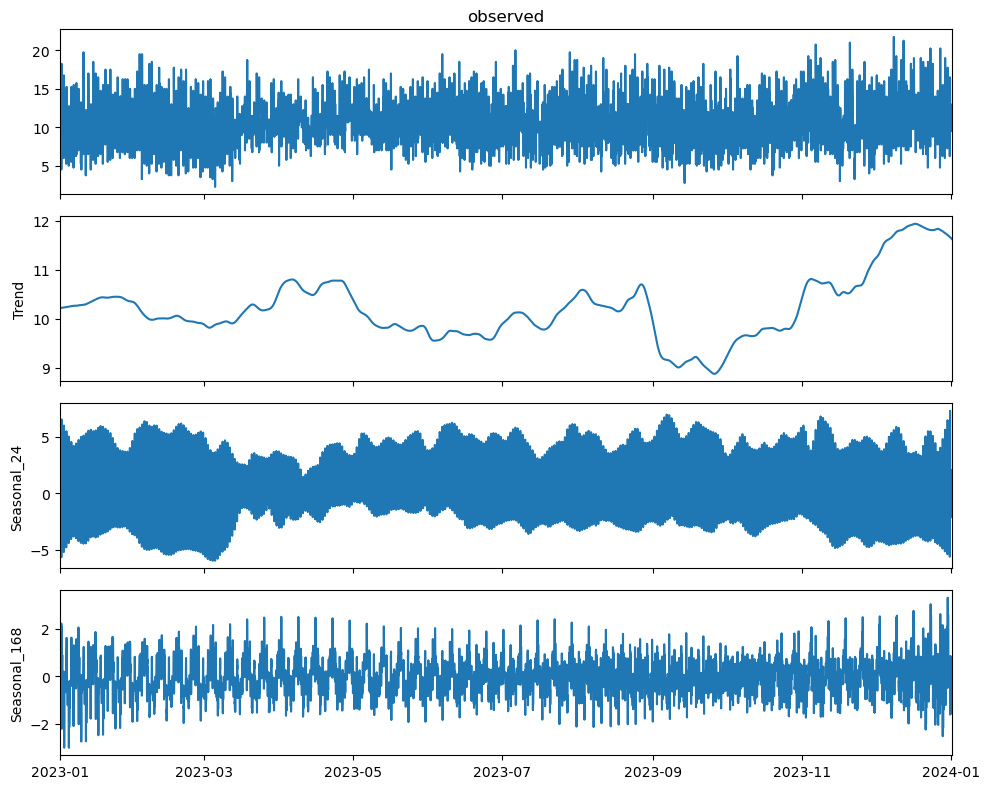

In [14]:
# Applying Multiple Seasonal Trend Decomposition
y_ms = df_h['count']
mstl = MSTL(y_ms, periods=[24, 24*7], iterate = 3)
res = mstl.fit()
print(res.seasonal)

# plot and print results
plt.rcParams['figure.figsize'] = (10,8)
res.plot(resid = False)
plt.show()

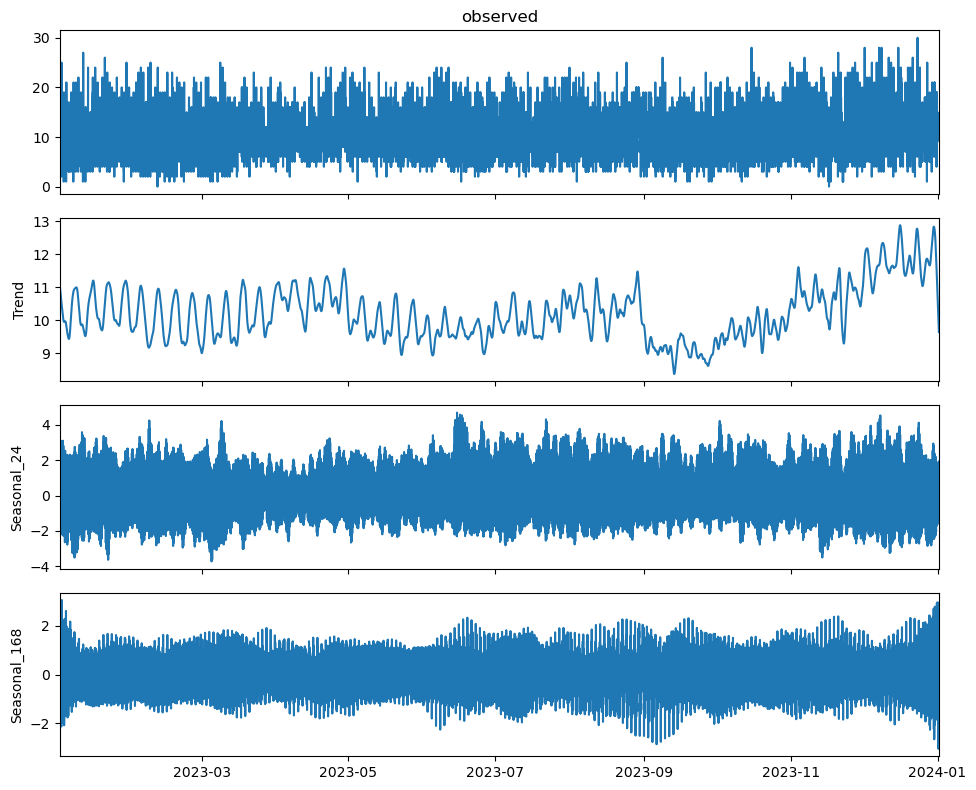

In [72]:
# Applying Multiple Seasonal Trend Decomposition
y = df['count']
mstl = MSTL(y, periods=[24, 24*7], iterate = 3)
res = mstl.fit()

# plot and print results
plt.rcParams['figure.figsize'] = (10,8)
res.plot(resid = False)
plt.show()

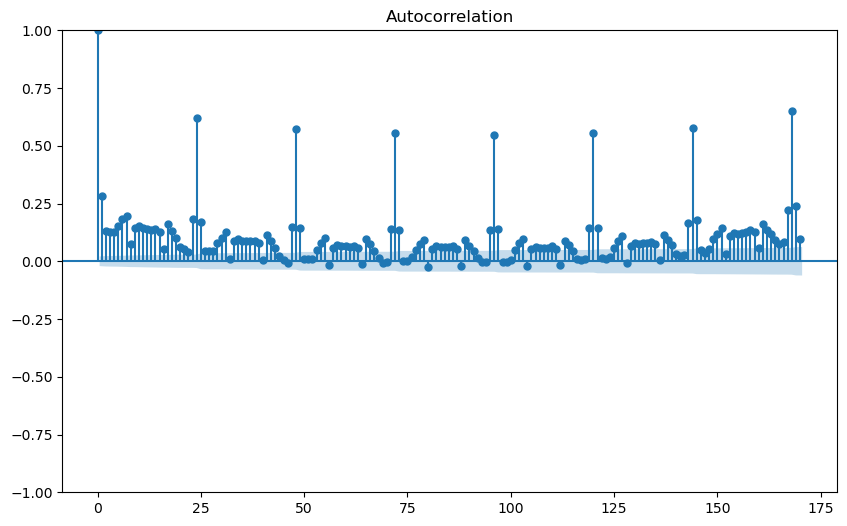

In [73]:
# Plotting the Autocorrelation Function
fig, ax = plt.subplots(figsize = (10, 6))

plot_acf(y_ms, lags = 170, ax = ax)
plt.show()

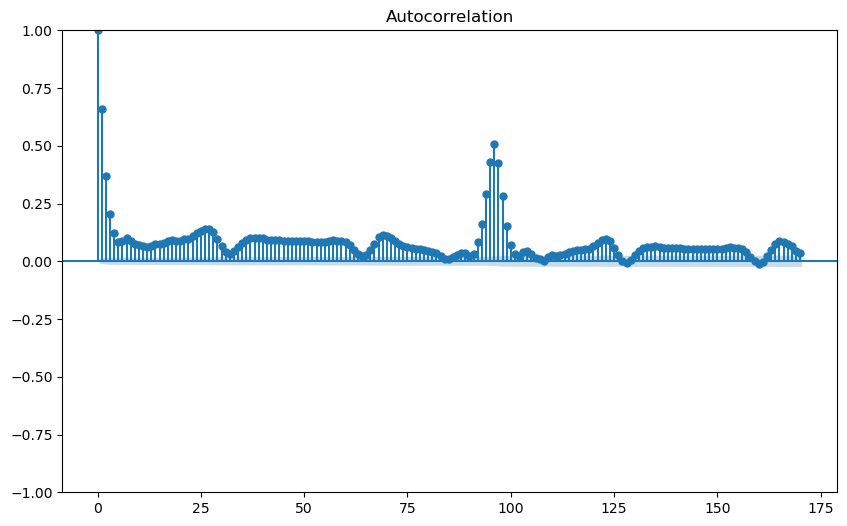

In [74]:
# Plotting the Autocorrelation Function
fig, ax = plt.subplots(figsize = (10, 6))

plot_acf(y, lags = 170, ax = ax)
plt.show()

---------------------
# TBATS FORECASTER #
--------------------
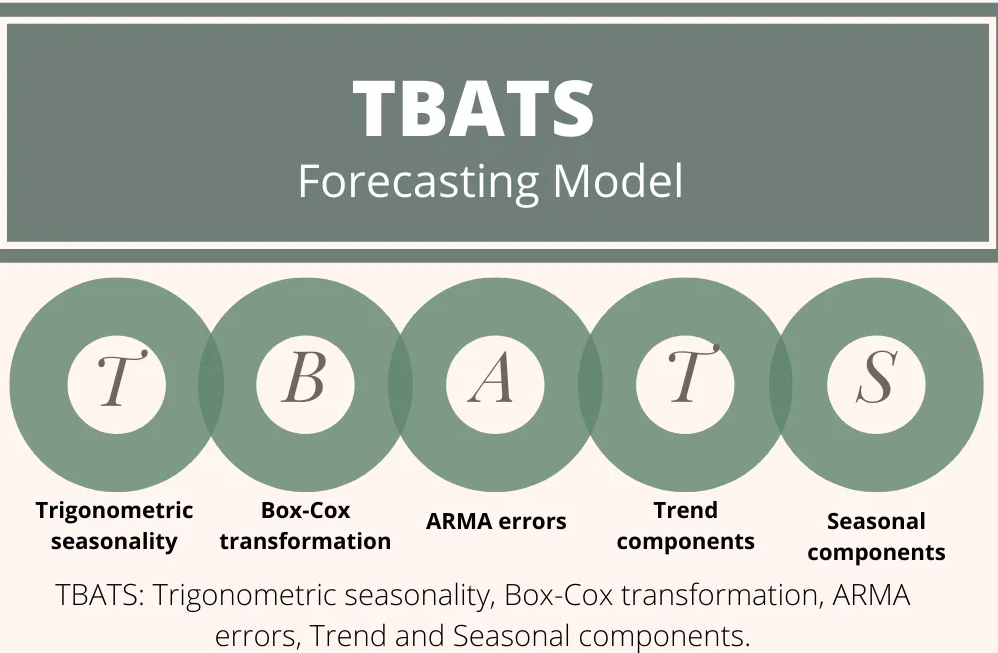

The TBATS model identified the seasonal patterns and generated a forecast very similar to the test set. Apart from the plot, the model accuracy is also evident in the metrics table, as they are all significantly lower than the naive model. This verifies that TBATS modeled our dataset accurately!

TBATS is ideal for time series datasets with complex seasonality but isn’t a general-purpose forecasting model. You should always conduct a time series analysis to understand the data and then choose the optimal forecasting model.

### Creating the TBATS Forecasting Model

> Train: 8606 Test: 168
> Predicted: 
2023-12-25 14:00:00     8.538241
2023-12-25 15:00:00    13.076128
2023-12-25 16:00:00    14.434333
2023-12-25 17:00:00    12.359476
2023-12-25 18:00:00    12.091067
                         ...    
2024-01-01 09:00:00    11.226806
2024-01-01 10:00:00    11.041759
2024-01-01 11:00:00    11.169727
2024-01-01 12:00:00    10.994426
2024-01-01 13:00:00    11.131598
Freq: h, Length: 168, dtype: float64

> Test data: 
2023-12-25 14:00:00     8.75
2023-12-25 15:00:00     6.00
2023-12-25 16:00:00    14.00
2023-12-25 17:00:00    13.50
2023-12-25 18:00:00    11.00
                       ...  
2024-01-01 09:00:00     9.50
2024-01-01 10:00:00     9.50
2024-01-01 11:00:00     9.50
2024-01-01 12:00:00     9.50
2024-01-01 13:00:00     9.50
Freq: h, Length: 168, dtype: float64
                   MAE  RMSE  MAPE  SMAPE
TBATS Forecaster  1.31  1.99  0.12   0.11


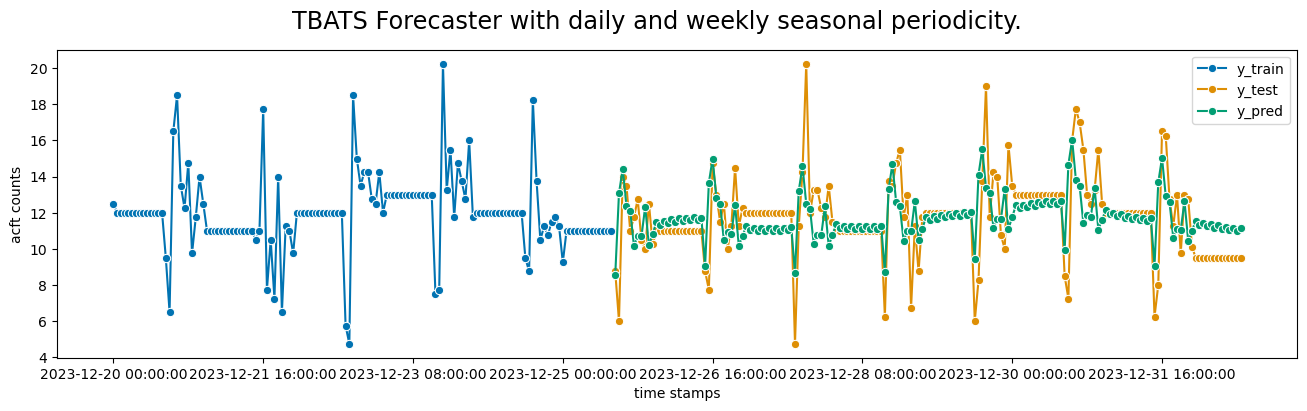

In [75]:
# n_jobs: int, optional (default=None)
# How many jobs to run in parallel when fitting BATS model. When not provided BATS shall try to utilize all available cpu cores.
forecaster = TBATS(sp = [24, 24*7]) #n_jobs = 4 ....12
forecaster.fit(y_train_h)
y_pred_tbats = forecaster.predict(fh=fh_h)

# plot and print results
plot_series(y_train_h['2023-12-20':], y_test_h, y_pred_tbats, labels=["y_train", "y_test", "y_pred"], y_label="acft counts", x_label="time stamps", title='TBATS Forecaster with daily and weekly seasonal periodicity.')

print(f'> Train: {y_train_h.shape[0]}', f'Test: {y_test_h.shape[0]}')
print(f'> Predicted: \n{y_pred_tbats}')

print(f'\n> Test data: \n{y_test_h}')
metrics_tbats_1 = print_metrics(y_test_h, y_pred_tbats, 'TBATS Forecaster')
print(metrics_tbats_1)

- ESTIMACION A CORTO PLAZO USANDO TBATS.

In [10]:
# Prepare data.
y = df['count']

# Split data in TRAIN and TESTING, 70% TRAIN, 30 TEST.
y_train, y_test = temporal_train_test_split(y, test_size = 168)

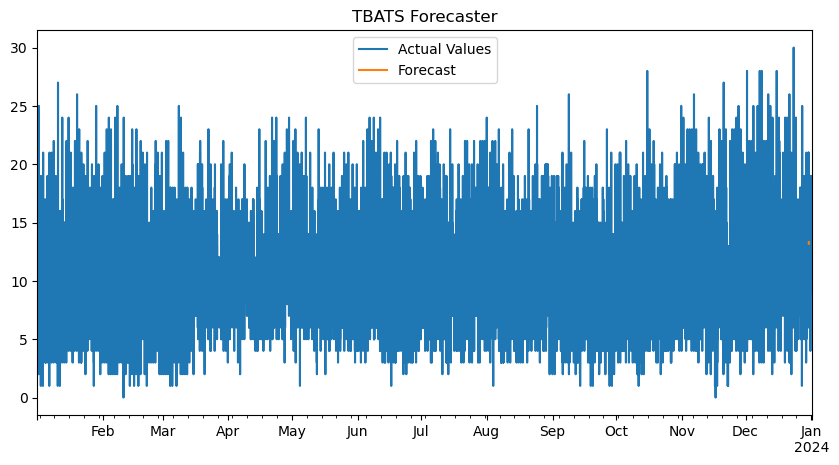

> Train: 34927 Test: 168
> Predicted: 
2023-12-30 20:00:00    13.184467
2023-12-30 20:15:00    13.270228
2023-12-30 20:30:00    13.323810
Freq: 15min, Name: count, dtype: float64

> Test datapoints subset to compare: 
timestamp
2023-12-30 20:00:00    14.0
2023-12-30 20:15:00    11.0
2023-12-30 20:30:00    13.0
2023-12-30 20:45:00    14.0
Freq: 15min, Name: count, dtype: float64
Error, MAPE metrics....
0


In [11]:
# Creating the TBATS Forecasting Model
forecaster = TBATS(sp = [24, 24*7]) #, n_jobs = 4 #12
forecaster.fit(y_train)
y_pred = forecaster.predict(fh=[1,2,3])

# plot and print results
fig, ax = plt.subplots(figsize = (10,5))  
df['count'].plot(title = 'TBATS Forecaster', xlabel = '', ax = ax)
y_pred.plot(ax = ax)
ax.legend(['Actual Values', 'Forecast'])
plt.show()

# print_metrics(y_test, y_pred, 'TBATS Forecaster')
print(f'> Train: {y_train.shape[0]}', f'Test: {y_test.shape[0]}')
print(f'> Predicted: \n{y_pred}')

# evaluate metrics in range fh
y_test_eval = y_test.iloc[:4]
print(f'\n> Test datapoints subset to compare: \n{y_test_eval}')
metrics_tbats_2 = print_metrics(y_test_eval, y_pred, 'Naive Forecaster')
print(metrics_tbats_2)

In [13]:
y_test_eval

timestamp
2023-12-30 20:00:00    14.0
2023-12-30 20:15:00    11.0
2023-12-30 20:30:00    13.0
2023-12-30 20:45:00    14.0
Freq: 15min, Name: count, dtype: float64

(<Figure size 1600x400 with 1 Axes>,
 <Axes: xlabel='time stamps', ylabel='acft counts'>)

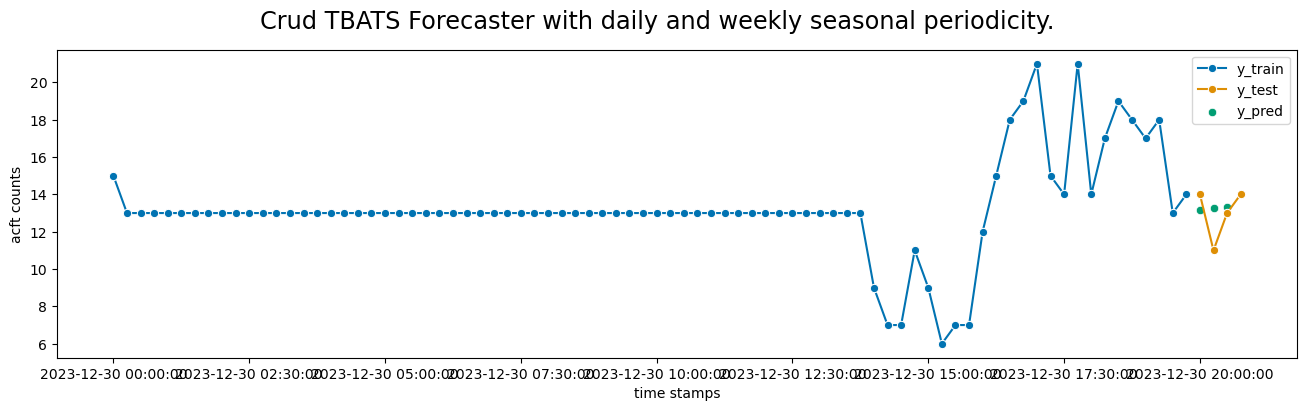

In [15]:
# plot and print results
plot_series(y_train['2023-12-30':], y_test_eval, y_pred, labels=["y_train", "y_test", "y_pred"], y_label="acft counts", x_label="time stamps", title='Crud TBATS Forecaster with daily and weekly seasonal periodicity.')


In [ ]:
forecaster = TBATS(sp=12, use_trend=True, use_box_cox=False)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

In [ ]:
from sktime.datasets import load_airline
from sktime.forecasting.tbats import TBATS
y = load_airline()
forecaster = TBATS(  
    use_box_cox=False,
    use_trend=False,
    use_damped_trend=False,
    sp=12,
    use_arma_errors=False,
    n_jobs=1)
forecaster.fit(y)  
y_pred = forecaster.predict(fh=[1,2,3])  

In [ ]:
# plot and print results
plot_series(y, y_pred, labels=[ "y" , "y_pred" ])

## Pronosticadores en sktime: búsqueda, propiedades, familias principales ##

In [137]:
from sktime.registry import all_estimators

all_estimators("forecaster", as_dataframe=True)

,name,object
0,ARCH,<class 'sktime.forecasting.arch._uarch.ARCH'>
1,ARDL,<class 'sktime.forecasting.ardl.ARDL'>
2,ARIMA,<class 'sktime.forecasting.arima._pmdarima.ARI...
3,AutoARIMA,<class 'sktime.forecasting.arima._pmdarima.Aut...
4,AutoETS,<class 'sktime.forecasting.ets.AutoETS'>
...,...,...
74,VAR,<class 'sktime.forecasting.var.VAR'>
75,VARMAX,<class 'sktime.forecasting.varmax.VARMAX'>
76,VECM,<class 'sktime.forecasting.vecm.VECM'>
77,YfromX,<class 'sktime.forecasting.compose._reduce.Yfr...


In [138]:
from sktime.registry import all_estimators

all_estimators(
    "forecaster", as_dataframe=True, return_tags=["scitype:y", "requires-fh-in-fit"]
)

,name,object,scitype:y,requires-fh-in-fit
0,ARCH,<class 'sktime.forecasting.arch._uarch.ARCH'>,univariate,False
1,ARDL,<class 'sktime.forecasting.ardl.ARDL'>,univariate,False
2,ARIMA,<class 'sktime.forecasting.arima._pmdarima.ARI...,univariate,False
3,AutoARIMA,<class 'sktime.forecasting.arima._pmdarima.Aut...,univariate,False
4,AutoETS,<class 'sktime.forecasting.ets.AutoETS'>,univariate,False
...,...,...,...,...
74,VAR,<class 'sktime.forecasting.var.VAR'>,multivariate,False
75,VARMAX,<class 'sktime.forecasting.varmax.VARMAX'>,multivariate,False
76,VECM,<class 'sktime.forecasting.vecm.VECM'>,multivariate,False
77,YfromX,<class 'sktime.forecasting.compose._reduce.Yfr...,univariate,False
